In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt  
import math          

(1158, 868, 3)


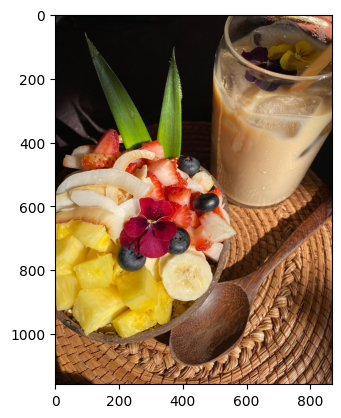

In [2]:
img = Image.open('desayuno.jpg')
img = np.array(img)
print(img.shape)
plt.imshow(img)
plt.show()

In [3]:
def powClose(cantidad):
    potencia_menor = math.floor(math.log2(cantidad))
    potencia_dos_menor_cercana = pow(2, potencia_menor)
    return potencia_dos_menor_cercana

def recortarImg(img):
    Xc, Yc = img.shape[1], img.shape[0]
    newH = powClose(img.shape[0])
    newW = powClose(img.shape[1])
    p1 = math.floor((Xc - newW) / 2)
    p2 = math.floor((Yc - newH) / 2)
    return img[p2:p2+newH, p1:p1+newW]

(1024, 512, 3)


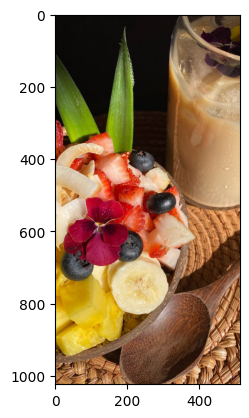

In [4]:
img_recortada = recortarImg(img)
print(img_recortada.shape)
plt.imshow(img_recortada)
plt.show()

In [5]:
def grayScale2(img):
    img = np.array(img)
    imgR = np.zeros((img.shape[0], img.shape[1]))
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            r, g , b  = img[y, x, 0], img[y, x, 1], img[y, x, 2]
            prom = int(0.299 * r + 0.587 * g + 0.114 * b) 
            imgR[y, x] = prom
    return imgR

(1024, 512)


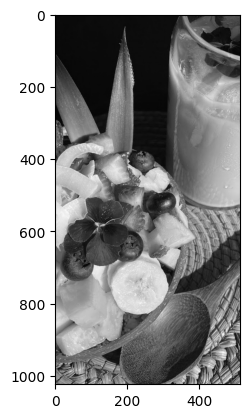

In [6]:
gray = grayScale2(img_recortada)
print(gray.shape)
plt.imshow(gray, cmap='gray')
plt.show()

In [7]:
def FFT(x):
    Y = x.shape[0]
    if Y == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        C = np.exp(-2j * np.pi * np.arange(Y) / Y)
        even_c = C[:Y//2]
        odd_c = C[Y//2:]

        even_part = X_even + even_c * X_odd
        odd_part = X_even + odd_c * X_odd

        X = np.concatenate((even_part, odd_part))
        return X

def FFT_2D(matriz):
    matriz = recortarImg(matriz)
    
    rows = np.zeros_like(matriz, dtype=np.complex128)
    for i in range(matriz.shape[0]):
        rows[i, :] = FFT(matriz[i, :])

    finalFFT2 = np.zeros_like(matriz, dtype=np.complex128)
    for j in range(matriz.shape[1]):
        finalFFT2[:, j] = FFT(rows[:, j])

    return finalFFT2

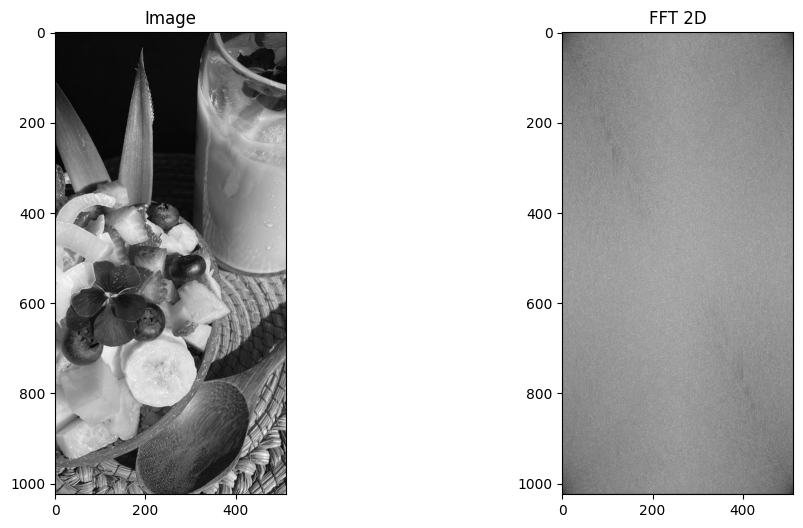

In [8]:
resultFFT = FFT_2D(gray)

plt.figure(figsize=(12,6))                   
plt.subplot(1,2,1) ; plt.title('Image')       
plt.imshow(gray, cmap="gray")                
plt.subplot(1,2,2) ; plt.title('FFT 2D')      
plt.imshow((np.log(1+abs(resultFFT))), cmap="binary") 

In [9]:
def centerInfoFFT(matrix):
    filas, columnas = matrix.shape

    Xc = filas // 2
    Yc = columnas // 2

    matrixRes = np.zeros_like(matrix)

    matrixRes[:Xc, :Yc] = matrix[-Xc:, -Yc:]
    matrixRes[-Xc:, -Yc:] = matrix[:Xc, :Yc]
    matrixRes[:Xc, -Yc:] = matrix[-Xc:, :Yc]
    matrixRes[-Xc:, :Yc] = matrix[:Xc, -Yc:]

    return matrixRes

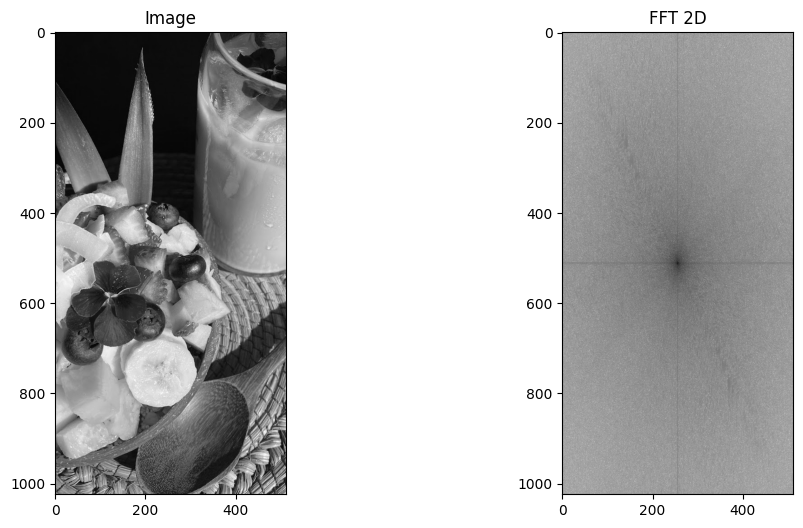

In [10]:
centeredFFT = centerInfoFFT(resultFFT)
plt.figure(figsize=(12,6))                   
plt.subplot(1,2,1) ; plt.title('Image')       
plt.imshow(gray, cmap="gray")                
plt.subplot(1,2,2) ; plt.title('FFT 2D')      
plt.imshow((np.log(1+abs(centeredFFT))), cmap="binary") 

In [11]:
def recortarMask(mask, percent):
    height, width = mask.shape[:2]
    center_x = width // 2
    center_y = height // 2
    
    newW = int(width * (1 - percent / 100) / 2)
    newH = int(height * (1 - percent / 100) / 2)

    MaskRes = mask[center_y - newH:center_y + newH,
                           center_x - newW:center_x + newW]

    return recortarImg(MaskRes)

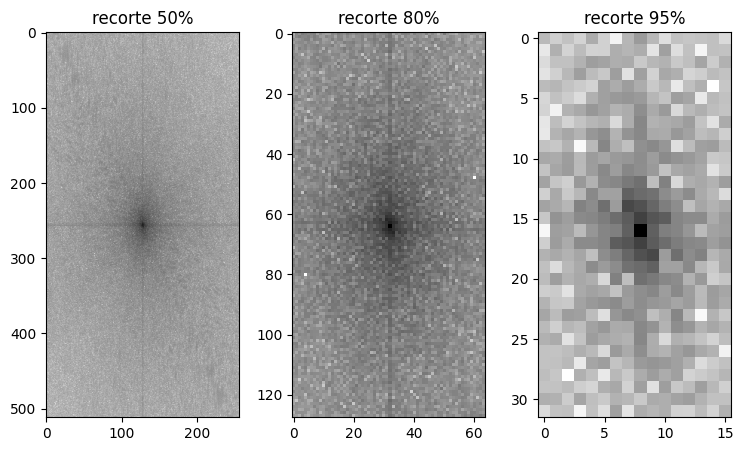

In [23]:
plt.figure(figsize=(9,5))    
cortada50 = recortarMask(centeredFFT, 50)
plt.subplot(1,3,1) ; plt.title('recorte 50%')  
plt.imshow((np.log(1+abs(cortada50))), cmap='binary')

cortada80 = recortarMask(centeredFFT, 80)
plt.subplot(1,3,2) ; plt.title('recorte 80%')  
plt.imshow((np.log(1+abs(cortada80))), cmap='binary')

cortada95 = recortarMask(centeredFFT, 95)
plt.subplot(1,3,3) ; plt.title('recorte 95%')  
plt.imshow((np.log(1+abs(cortada95))), cmap='binary')


In [13]:
def IFFT(x):
    Y = x.shape[0]
    if Y == 1:
        return x
    else:
        X_even = IFFT(x[::2])
        X_odd = IFFT(x[1::2])
        C = np.exp(2j * np.pi * np.arange(Y) / Y)
        even_c = C[:Y//2]
        odd_c = C[Y//2:]

        even_part = X_even + even_c * X_odd
        odd_part = X_even + odd_c * X_odd

        X = np.concatenate((even_part, odd_part))
        return X
    
def IFFT_2D(matrix):
    rows = np.zeros_like(matrix, dtype=np.complex128)
    for i in range(matrix.shape[0]):
        rows[i, :] = IFFT(matrix[i, :])

    finalIFFT2 = np.zeros_like(matrix, dtype=np.complex128)
    for j in range(matrix.shape[1]):
        finalIFFT2[:, j] = IFFT(rows[:, j])

    return finalIFFT2

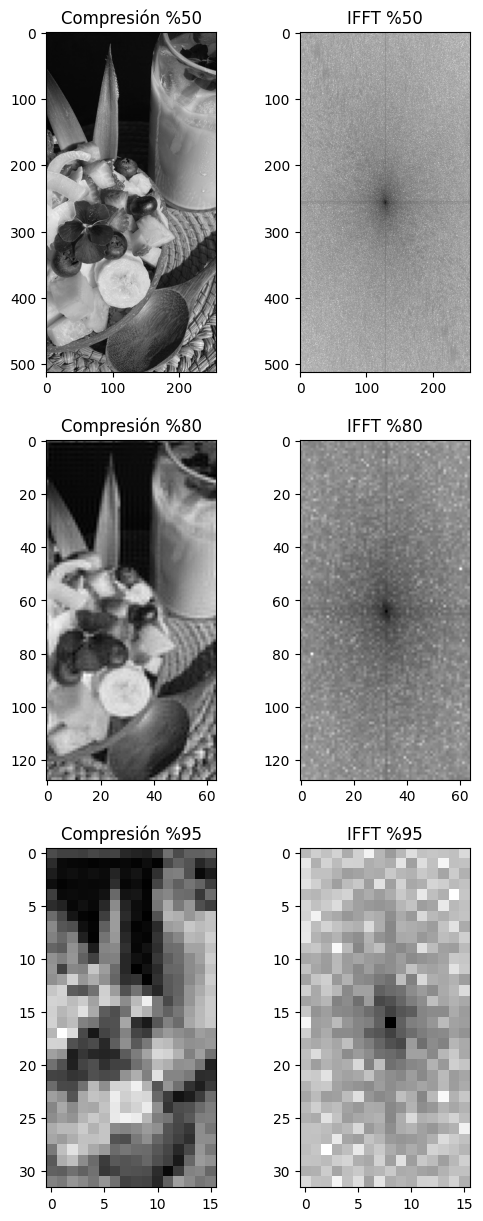

In [35]:
plt.figure(figsize=(6,15)) 
compresion50 = centerInfoFFT(cortada50)
compressedImg50= np.abs(IFFT_2D(compresion50))                  
plt.subplot(3,2,1) ; plt.title('Compresión %50')       
plt.imshow(compressedImg50, cmap="gray")                
plt.subplot(3,2,2) ; plt.title('IFFT %50')      
plt.imshow((np.log(1+abs(cortada50))), cmap="binary") 


compresion80 = centerInfoFFT(cortada80)
compressedImg80= np.abs(IFFT_2D(compresion80))                   
plt.subplot(3,2,3) ; plt.title('Compresión %80')       
plt.imshow(compressedImg80, cmap="gray")                
plt.subplot(3,2,4) ; plt.title('IFFT %80')      
plt.imshow((np.log(1+abs(cortada80))), cmap="binary")

compresion95 = centerInfoFFT(cortada95)
compressedImg95= np.abs(IFFT_2D(compresion95))                   
plt.subplot(3,2,5) ; plt.title('Compresión %95')       
plt.imshow(compressedImg95, cmap="gray")                
plt.subplot(3,2,6) ; plt.title('IFFT %95')      
plt.imshow((np.log(1+abs(cortada95))), cmap="binary")
